In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Importing the data into the notebook
import os
os.chdir('/Users/naveenrowthula/Downloads/competitive-data-science-predict-future-sales/')
sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
shops = pd.read_csv('shops.csv')
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')

FileNotFoundError: [Errno 2] File shops_updated.csv does not exist: 'shops_updated.csv'

In [3]:
# splitting the date into year month using datetime for visualization.

sales_train['year'] = pd.to_datetime(sales_train['date']).dt.strftime('%Y')
sales_train['month'] = sales_train.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').strftime('%m')) 

sales_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,02.01.2013,0,59,22154,999.0,1.0,2013,01
1,03.01.2013,0,25,2552,899.0,1.0,2013,01


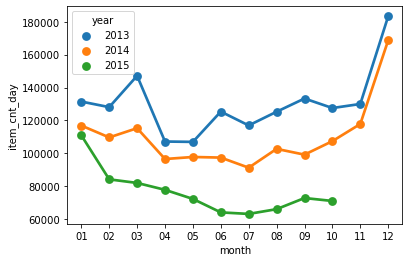

In [4]:

%matplotlib inline 

grouped = pd.DataFrame(sales_train.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=grouped)

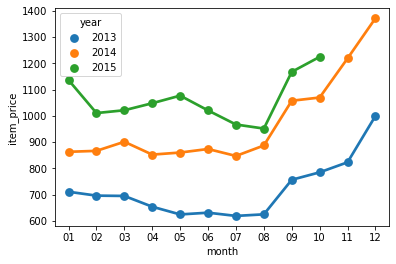

In [5]:
grouped_price = pd.DataFrame(sales_train.groupby(['year','month'])['item_price'].mean().reset_index())
sns.pointplot(x='month', y='item_price', hue='year', data=grouped_price)

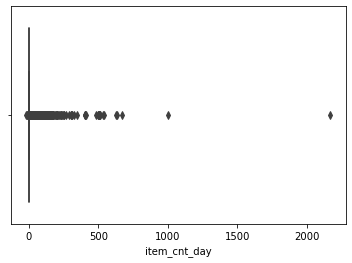

In [6]:
# Detecting outliers for items sold in a day
sns.boxplot(sales_train['item_cnt_day'],data = sales_train)

In [7]:
# Now we remove outliers, the values above 1000 are outliers
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

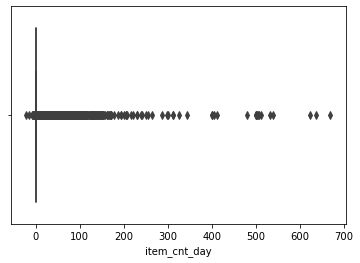

In [8]:
sns.boxplot(sales_train['item_cnt_day'],data = sales_train)

In [9]:
# Checking for NULL or missing values
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
year              0
month             0
dtype: int64

In [10]:
# Now we group data based on month,shop_id and item_id and sum up the item count for each month.
sales_train = sales_train.groupby(['date_block_num','shop_id','item_id'],as_index=False).agg({'item_cnt_day':'sum'}, dtype='int32')
sales_train = sales_train.rename(columns = {'item_cnt_day':'item count'})

In [11]:
sales_train.head()

,date_block_num,shop_id,item_id,item count
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [12]:
sales_train.min()

date_block_num     0.0
shop_id            0.0
item_id            0.0
item count       -22.0
dtype: float64

In [13]:
# We exclude rows having negative values and for better performance we are considering rows whose count is greater than 1.
train_data = sales_train[sales_train['item count'] > 1]

In [14]:
train_data.describe()

,date_block_num,shop_id,item_id,item count
count,546800.000000,546800.000000,546800.000000,546800.000000
mean,14.750770,33.052644,9813.068661,4.731531
std,9.435932,16.133664,6257.313255,14.137984
min,0.000000,0.000000,1.000000,2.000000
25%,7.000000,22.000000,4252.000000,2.000000
50%,14.000000,31.000000,8093.000000,3.000000
75%,23.000000,47.000000,15238.000000,4.000000
max,33.000000,59.000000,22167.000000,1644.000000


In [15]:
train_data.shape

(546800, 4)

In [16]:
train_data.dtypes

date_block_num      int64
shop_id             int64
item_id             int64
item count        float64
dtype: object

In [17]:
train_data.head()

,date_block_num,shop_id,item_id,item count
0,0,0,32,6.0
1,0,0,33,3.0
4,0,0,51,2.0
10,0,0,98,25.0
12,0,0,149,3.0


In [18]:
# Now we convert the data types of month,shop_id and item_id to categorical.
train_data[['date_block_num','shop_id','item_id']] = train_data[['date_block_num','shop_id','item_id']].astype('category')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [19]:
#Implementing random forest to predict the prices.

In [91]:
# This code splits the data into features and labels.
train_features_rf = train_data.drop(['item count'],axis=1)
train_labels_rf = train_data['item count']

In [92]:
# Using train_test_split we are splitting the data for training and testing.
X_train,X_test,Y_train,Y_test = train_test_split(train_features_rf,train_labels_rf,test_size=0.25,random_state=22)

In [93]:
#Fitting the Random Forest model to the train data and predicting on the test data.
model = RandomForestRegressor()
model.fit(X_train, Y_train)
res = model.predict(X_test)

In [94]:
print(res)

[4.07 2.12 2.61 ... 3.71 4.39 2.95]


In [152]:
output = pd.DataFrame(res,Y_test.values)
output.rename(columns = {0:'Predicted values'},inplace=True)
output.head()

,Predicted values
3.0,4.07
2.0,2.12
2.0,2.61
3.0,3.23
3.0,2.25


In [95]:
rmse = mean_squared_error(Y_test.values, res, squared=False)
rmse

9.052273079730965

In [25]:
# Optimizing the above model using hyper parameter tuning.

In [127]:
model = RandomForestRegressor(n_estimators = 300,max_depth=30,bootstrap=True)
model.fit(X_train, Y_train)
res1 = model.predict(X_test)

In [128]:
print(res1)

[3.71666667 2.15116869 2.53438034 ... 3.61799151 4.2100513  2.90666667]


In [153]:
output1 = pd.DataFrame(res1,Y_test.values)
output1.rename(columns = {0:'Predicted values'},inplace=True)
output1.head()

,Predicted values
3.0,3.716667
2.0,2.151169
2.0,2.534380
3.0,3.264490
3.0,2.314468


In [ ]:
# By hyperparameter tuning we reduced the prediction error as calculated below.

In [129]:
rmse = mean_squared_error(Y_test, res1, squared=False)
rmse

8.97648987428535